In this project, I will be using the U.S. Energy Information's Residential Energy Consumption Survey (RECS) to explore the role of household square footage on electricity usage. The RECS dataset includes detailed information on over 5,600 households in the USA. I will focus on only the total square footage (TOTSQFT_EN) and total site electricity usage, in kilowatthours, in 2015 (KWH) for apartments without high ceilings. Information on this rich dataset can be found here: https://www.eia.gov/consumption/residential/data/2015/index.php?view=microdata

For this project I utilize two resampling methods: cross-validation, and bootstrapping. Objectives for this project include:

1. Recognizing the pitfalls of overfitting, when it will occur.
2. Addressing the issue of overfitting the model by preparing the dataset for validation.
3. Understanding the trade-offs of different validation techniques: the validation set approach, k-fold cross-validation, and leave-one-out cross-validation.
4. Using bootstrapping to determine uncertainity in model coefficients.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



 isolate apartments without high ceilings from data. Since I will only be using the total square footage (TOTSQFT_EN) and total site electricity usage, in kilowatthours, in 2015 (KWH) for this project, I remove all other columns.

In [ ]:
# Read in the RECS dataset
RECS = pd.read_csv('data/recs2015_public.csv')

# Include only households that are apartments
RECS_APT = RECS.loc[RECS['TYPEHUQ'].isin([4,5])]

# Include only household that are apartments AND are do not have high ceilings.
RECS_APT = RECS_APT[RECS_APT['HIGHCEIL'] == 0]

# Include only the columns for the total square footage and
# total site electricity usage, in kilowatthours, in 2015.
RECS_APT = RECS_APT[['TOTSQFT_EN','KWH']]
#type(RECS_APT)
RECS_APT = RECS_APT.reset_index(drop=True)

RECS_APT.head()

,TOTSQFT_EN,KWH
0,623,2777.000
1,832,2397.758
2,782,6750.579
3,1597,20554.014
4,1222,2297.369


Visualize the data via a scatterplot of the total square footage of the apartment to the total electricity usage in the apartment.

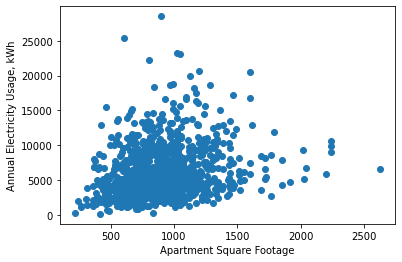

In [ ]:
plt.scatter(RECS_APT.TOTSQFT_EN, RECS_APT.KWH)
plt.xlabel('Apartment Square Footage')
plt.ylabel('Annual Electricity Usage, kWh')
plt.show()



I use the function train_test_split in sklearn to separate the data into two equally sized training and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(RECS_APT.TOTSQFT_EN, RECS_APT.KWH,
                                                    test_size = 0.5, # 50% of the data is in the test set and 50% of the data is in the training set
                                                    random_state = 0)# To ensure consistency in answer across students, we will randomly select the same observations

Here I fit the training set to a simply linear regression (a polynomial of order 1); then calculate the MSE of both the training set and testing set.


The MSE for the validation data is 12580887.
The MSE for the training data is   15085987.


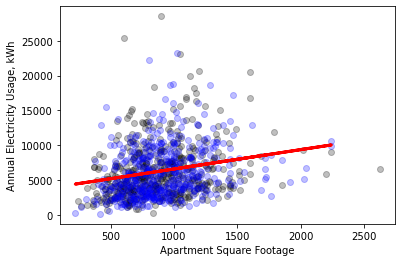

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Adding a column in the X matrices for the intercept
X_train_reshape = np.array(X_train).reshape(-1, 1)
X_val_reshape = np.array(X_val).reshape(-1, 1)

# Fit the simple linear regression using the training set.
regr = linear_model.LinearRegression()

# Fit the simple linear regression
regr.fit(X_train_reshape, y_train)

# Make predictions using the linear regression
y_pred_val = regr.predict(X_val_reshape)
y_pred_train = regr.predict(X_train_reshape)

# Print the MSE for both the validation and training sets
MSE_val = mean_squared_error(y_val,y_pred_val)
MSE_train = mean_squared_error(y_train,y_pred_train)
print('The MSE for the validation data is %i.' %MSE_val)
print('The MSE for the training data is   %i.' %MSE_train)

# Plot
plt.scatter(X_train, y_train,  color='black', alpha = 0.25)
plt.scatter(X_val, y_val,  color='blue', alpha = 0.25)
plt.plot(X_val, y_pred_val, color='red', linewidth=3)
plt.xlabel('Apartment Square Footage')
plt.ylabel('Annual Electricity Usage, kWh')
plt.show()

Next I fit the training set to a quadratic (a polynomial of order 2), and calculate the MSE of both the training set and testing set.

The MSE for the validation data is 12449415.
The MSE for the training data is   14931253.


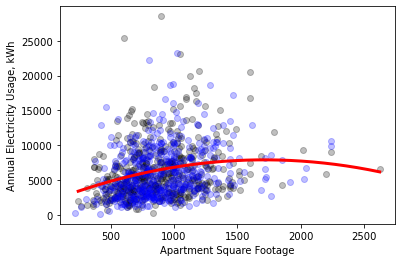

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Generate new feature matrices consisting of all polynomial combinations
# of Apartment Square Footage of order 2 or less
poly = PolynomialFeatures(2)
X_train_poly2 = poly.fit_transform(X_train_reshape)
X_val_poly2 = poly.fit_transform(X_val_reshape)

# Fit the polynomial regression of order 2 (quadratic) using the training set
regr = linear_model.LinearRegression()

# Fit the simple linear regression
regr.fit(X_train_poly2, y_train)

# Make predictions using the linear regression
y_pred_poly2_val = regr.predict(X_val_poly2)
y_pred_poly2_train = regr.predict(X_train_poly2)

# Print the MSE for both the val and training sets
MSE_val = mean_squared_error(y_val,y_pred_poly2_val)
MSE_train = mean_squared_error(y_train,y_pred_poly2_train)
print('The MSE for the validation data is %i.' %MSE_val)
print('The MSE for the training data is   %i.' %MSE_train)

# Plot
x = np.arange(min(X_train),max(X_train), .01)
xx = np.c_[np.ones(len(x)), x, x**2]
y_curve = np.dot(xx, regr.coef_.transpose())+regr.intercept_

plt.scatter(X_train, y_train,  color='black', alpha = 0.25)
plt.scatter(X_val, y_val,  color='blue', alpha = 0.25)
plt.plot(x, y_curve, color='red', linewidth=3)
plt.xlabel('Apartment Square Footage')
plt.ylabel('Annual Electricity Usage, kWh')
plt.show()

Next I create a function that will fit training data (X_train, y_train) to a polynomial of any order. The function will also calculate the MSE for both the training and validation sets, and return these values (MSE_train, MSE_val). The function will be called calc_MSE_polynomial_fit.

In [ ]:
def calc_MSE_polynomial_fit(poly_order, X_train, X_val, y_train, y_val):

        # Adding a column in the X matrices for the intercept
        X_train_reshape = np.array(X_train).reshape(-1, 1)
        X_val_reshape = np.array(X_val).reshape(-1, 1)

        # Generate new feature matrices consisting of all polynomial combinations
        poly = PolynomialFeatures(poly_order)
        X_train_poly2 = poly.fit_transform(X_train_reshape)
        X_val_poly2 = poly.fit_transform(X_val_reshape)

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Fit the simple linear regression
        regr.fit(X_train_poly2, y_train)

        # Make predictions using the linear regression
        y_pred_poly2_val = regr.predict(X_val_poly2)
        y_pred_poly2_train = regr.predict(X_train_poly2)

        # Print the MSE for both the val and training sets
        MSE_val = mean_squared_error(y_val,y_pred_poly2_val)
        MSE_train = mean_squared_error(y_train,y_pred_poly2_train)

        return MSE_train, MSE_val

Here I test function on training and validation data

In [ ]:
[MSE_train, MSE_val] = calc_MSE_polynomial_fit(1, X_train_reshape, X_val_reshape, y_train, y_val)
print('The MSE for the validation data is %i.' %MSE_val)
print('The MSE for the training data is   %i.' %MSE_train)

The MSE for the validation data is 12580887.
The MSE for the training data is   15085987.


Now I consider polynomials of order 1 through 10, then calculate and plot the training and validation MSEs.

In [ ]:
MSE_val_array = []
MSE_train_array = []
for poly_order in range(1,11):
    [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_train_reshape, X_val_reshape, y_train, y_val)
    MSE_val_array.append(MSE_val)
    MSE_train_array.append(MSE_train)

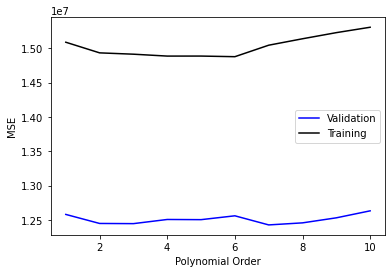

In [ ]:
poly_order = np.arange(1,11)
plt.plot(poly_order,MSE_val_array, 'blue', label= 'Validation')
plt.plot(poly_order,MSE_train_array, 'black', label = 'Training')
plt.xlabel('Polynomial Order')
plt.ylabel('MSE')
plt.legend()
plt.show()

Here I determine the polynomial order that produces the minimum MSE of the validation set.

In [ ]:
MSE_val_min = np.amin(MSE_val_array)
poly_order_MSE_val_min = np.argmin(MSE_val_array) + 1

print('The minimum MSE for the validation data is %i.' %MSE_val_min)
print('This occurs when using a model of polynomial order %i.' %poly_order_MSE_val_min)

The minimum MSE for the validation data is 12428199.
This occurs when using a model of polynomial order 7.


When the data was randomly split in half, it was arbitrary which half was assigned to the training set and which half was assigned to the validation set. Let's switch the training and validation test set and repeat the previous analysis.

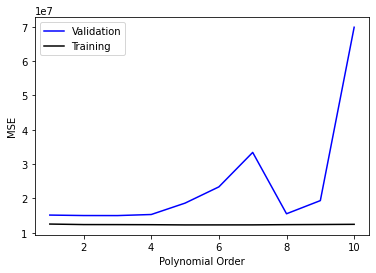

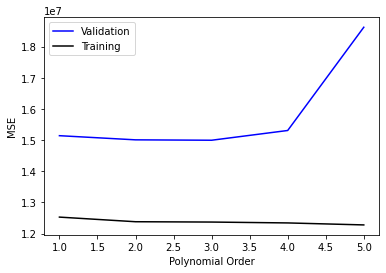

In [ ]:
# Switch the training and validation sets
X_train_switch = X_val_reshape
X_val_switch  = X_train_reshape
y_train_switch = y_val
y_val_switch  = y_train

# Calculate the MSE of the training and validation sets for polynomials of order 1-10
MSE_val_array = []
MSE_train_array = []
for poly_order in range(1,11):
    [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_train_switch, X_val_switch, y_train_switch, y_val_switch)
    MSE_val_array.append(MSE_val)
    MSE_train_array.append(MSE_train)

# Plot training and validation MSE for polynomials of order 1-10
poly_order = np.arange(1,11)
plt.plot(poly_order,MSE_val_array, 'blue', label= 'Validation')
plt.plot(poly_order,MSE_train_array, 'black', label = 'Training')
plt.xlabel('Polynomial Order')
plt.ylabel('MSE')
plt.legend()
plt.show()

# This can be achieved using slices.
lower_limit = 1
upper_limit = 5
poly_order = np.arange(lower_limit,upper_limit+1)
plt.plot(poly_order[lower_limit-1:upper_limit],MSE_val_array[lower_limit-1:upper_limit], 'blue', label= 'Validation')
plt.plot(poly_order[lower_limit-1:upper_limit],MSE_train_array[lower_limit-1:upper_limit], 'black', label = 'Training')
plt.xlabel('Polynomial Order')
plt.ylabel('MSE')
plt.legend()
plt.show()

With the training and validation sets switched, I check what polynomial order yields the lowest MSE



 The optimal polynomial order is 3. I don't make this prediction with a high level of confidence because the models have only been tested on two data sets. I would like to evaluate the perfomance of the models on more data sets

In [ ]:
MSE_val_min = np.min(MSE_val_array)
poly_order_MSE_val_min = np.argmin(MSE_val_array) + 1

print('The minimum MSE for the validation data is %i.' %MSE_val_min)
print('This occurs when using a model of polynomial order %i.' %poly_order_MSE_val_min)

The minimum MSE for the validation data is 14995288.
This occurs when using a model of polynomial order 3.


 First I setup a 2-fold cross-validation to determine the polynomial order the will minimize the average validation MSE, and the average validation MSE at that polynomial order.

First I create the 2 folds; each with half the data.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=0)

fold = 0
for train_index, val_index in kf.split(RECS_APT):
    print("Fold", fold)
    print("Train:", train_index, "Validation:",val_index, '\n')
    fold+=1

The code below performs a 2-fold cross-validation to determine the average MSE of the validation sets across all folds for polynomials of order 1 to 10.

In [ ]:
X = RECS_APT.TOTSQFT_EN
y = RECS_APT.KWH


kf = KFold(n_splits=2, shuffle=True, random_state=0)

mses = pd.DataFrame()
fold = 0
for train_index, val_index in kf.split(X):
    # Separate each array into respective variables
    X_fold_train = X[train_index]
    y_fold_train = y[train_index]
    X_fold_val = X[val_index] # Enter the appropriate indices
    y_fold_val = y[val_index] # Enter the appropriate indices

    # Adding a column in the X matrices for the intercept
    X_fold_train = np.array(X_fold_train).reshape(-1, 1)
    X_fold_val = np.array(X_fold_val).reshape(-1, 1)

    # Calculate the MSE for each polynomial order
    MSE_val_array = []
    MSE_train_array = []
    for poly_order in range(1,11):
        [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_fold_train, X_fold_val, y_fold_train, y_fold_val)
        MSE_val_array.append(MSE_val)
        MSE_train_array.append(MSE_train)
    mses[fold] = MSE_val_array
    fold = fold+1

# Average the MSE across folds
mses['mses_ave'] = mses.mean(axis=1)

In [ ]:
mses

,0,1,mses_ave
0,1.258089e+07,1.514128e+07,1.386109e+07
1,1.244942e+07,1.500798e+07,1.372870e+07
2,1.244686e+07,1.499529e+07,1.372107e+07
3,1.250734e+07,1.530820e+07,1.390777e+07
4,1.250851e+07,1.874555e+07,1.562703e+07
5,1.256059e+07,2.334381e+07,1.795220e+07
6,1.242820e+07,3.340878e+07,2.291849e+07
7,1.245806e+07,1.552475e+07,1.399140e+07
8,1.253143e+07,1.935642e+07,1.594393e+07
9,1.263303e+07,6.983649e+07,4.123476e+07


A plot of the MSE of the validation set for each of the folds, as well as the average of the two folds.

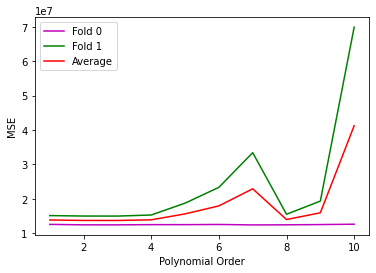

In [ ]:
poly_order = np.arange(1,11)
plt.plot(poly_order, mses[0], 'm', label= 'Fold 0')
plt.plot(poly_order, mses[1], 'green', label= 'Fold 1')
plt.plot(poly_order, mses['mses_ave'], 'red', label= 'Average')
plt.xlabel('Polynomial Order')
plt.ylabel('MSE')
plt.legend()
plt.show()



Code below to computes the minimum MSE of the validation sets averaged across all folds and at which polynomial order this occurs.

In [ ]:
MSE_ave_val_min = mses['mses_ave'].min()
poly_order_MSE_ave_val_min = list(mses['mses_ave'][mses['mses_ave'] \
                                                   == MSE_ave_val_min].index)[0] + 1

print('The minimum average validation MSE is %i.' %MSE_ave_val_min)
print('This occurs when using a model of polynomial order %i.' %poly_order_MSE_ave_val_min)

The minimum average validation MSE is 13721072.
This occurs when using a model of polynomial order 3.


Now I create a general function that will do a k-fold cross-validation for polynomials up to and including a max polynomial order. This function will return the minimum MSE of the validation sets averaged across all folds and at which polynomial order this occurs.

In [ ]:
def poly_order_cv(X,y,k,poly_order_max):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)

    mses = pd.DataFrame()
    fold = 0
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]

        # Adding a column in the X matrices for the intercept
        X_fold_train = np.array(X_fold_train).reshape(-1, 1)
        X_fold_val = np.array(X_fold_val).reshape(-1, 1)

        # Calculate the MSE for each polynomial order
        MSE_val_array = []
        MSE_train_array = []
        for poly_order in range(1,poly_order_max + 1):
            [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_fold_train, X_fold_val, y_fold_train, y_fold_val)
            MSE_val_array.append(MSE_val)
            MSE_train_array.append(MSE_train)
        mses[fold] = MSE_val_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    MSE_ave_val_min = mses['mses_ave'].min()
    poly_order_MSE_ave_val_min = list(mses['mses_ave'][mses['mses_ave'] == MSE_ave_val_min].index)[0] + 1

    return MSE_ave_val_min, poly_order_MSE_ave_val_min

I test this function on a 2-fold validation to check if it works (gives the same result as the previous 2-fold validtion done above

In [ ]:
X = RECS_APT.TOTSQFT_EN
y = RECS_APT.KWH
k = 2
poly_order_max = 10
[MSE_ave_val_min, poly_order_MSE_ave_val_min] = poly_order_cv(X,y,k,poly_order_max)

print('The minimum average validation MSE is %i.' %MSE_ave_val_min)
print('This occurs when using a model of polynomial order %i.' %poly_order_MSE_ave_val_min)

The minimum average validation MSE is 13721072.
This occurs when using a model of polynomial order 3.


Now I consider the effect of k (number of folds). I vary k from 2 to 20. For each k, I determine the polynomial order where the minimum average validation MSE occurs. Then I plot k on the x-axis and the polynomial order where the minimum average validation MSE occurs on the y-axis.

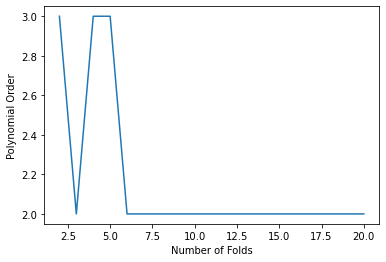

In [ ]:
X = RECS_APT.TOTSQFT_EN
y = RECS_APT.KWH
poly_order_max = 10

#arrays to store best polynomial for each k
MSE_ave_val_min_k = []
poly_order_MSE_ave_val_min_k = []

for k in range(2,21):
    [MSE_ave_val_min, poly_order_MSE_ave_val_min] = poly_order_cv(X,y,k,poly_order_max)
    MSE_ave_val_min_k.append(MSE_ave_val_min)
    poly_order_MSE_ave_val_min_k.append(poly_order_MSE_ave_val_min)

k_value = np.arange(2,21)
plt.plot(k_value, poly_order_MSE_ave_val_min_k)
plt.xlabel('Number of Folds')
plt.ylabel('Polynomial Order')
plt.show()




Next we use leave-one-out cross-validation to determine the optimal polynomial order

In [ ]:
X = RECS_APT.TOTSQFT_EN
y = RECS_APT.KWH
k = len(X)
poly_order_max = 10
[MSE_ave_val_min, poly_order_MSE_ave_val_min] = poly_order_cv(X,y,k,poly_order_max)

print('The minimum average validation MSE is %i.' %MSE_ave_val_min)
print('This occurs when using a model of polynomial order %i.' %poly_order_MSE_ave_val_min)

The minimum average validation MSE is 13743291.
This occurs when using a model of polynomial order 2.


In [ ]:
# Some thoughts
# I believe that the polynomial of order 2 is the best model because it has a low variance while being more flexible than a linear model
# Furthermore, it yields the minimum errors in validation set approach, and also in the majority of  k-fold cross-validation for k values between
# 4 and 10, a range that has a good compromise between variance and bias for the k-fold cross-validation approach

 Next I will model the relationship between apartment square footage and annual electricity usage as a polynomial of order 2. Then I will then apply bootstrap to visualize the 95% confidence interval and determine the standard errors for each coefficient.


The coefficients (betas as shown in Equation 1) are:
Beta_0 =  1413.9042498593935
Beta_1 =  7.5141475908085225
Beta_2 =  -0.002205395398713843


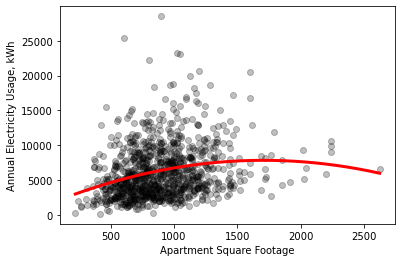

In [ ]:
X = RECS_APT.TOTSQFT_EN
y = RECS_APT.KWH

# Adding a column in the X matrices for the intercept
X_reshape = np.array(X).reshape(-1, 1)

# Generate new feature matrices consisting of all polynomial combinations
# of Apartment Square Footage of order 2 or less
poly = PolynomialFeatures(2)
X_poly2 = poly.fit_transform(X_reshape)

# Fit the polynomial regression of order 2 (quadratic)
regr.fit(X_poly2, y)

# Print the coefficients
print('The coefficients (betas as shown in Equation 1) are:')
print('Beta_0 = ', regr.intercept_)
print('Beta_1 = ', regr.coef_[1])
print('Beta_2 = ', regr.coef_[2])

# Plot
x = np.arange(min(X),max(X), .01)
xx = np.c_[np.ones(len(x)), x, x**2]
y_curve = np.dot(xx, regr.coef_.transpose())+regr.intercept_

plt.scatter(X, y,  color='black', alpha = 0.25)
plt.plot(x, y_curve, color='red', linewidth=3)
plt.xlabel('Apartment Square Footage')
plt.ylabel('Annual Electricity Usage, kWh')
plt.show()

The package StatsModels can also be used, as can be seen in the cell below. One advantage of using StatsModels is that the standard error of each coefficient is printed in the summary of the results.

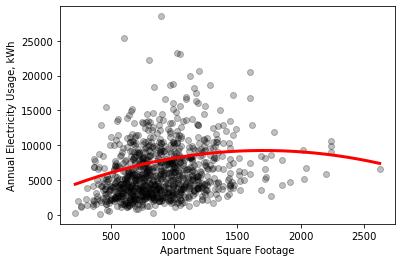

                            OLS Regression Results                            
Dep. Variable:                    KWH   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     31.94
Date:                Fri, 09 Oct 2020   Prob (F-statistic):           3.78e-14
Time:                        15:35:27   Log-Likelihood:                -9094.9
No. Observations:                 944   AIC:                         1.820e+04
Df Residuals:                     941   BIC:                         1.821e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1413.9042    779.671      1.813      0.0

In [ ]:
import statsmodels.api as sm

X = RECS_APT.TOTSQFT_EN
y = RECS_APT.KWH

# Adding a column in the X matrices for the intercept
X_reshape = np.array(X).reshape(-1, 1)

# Generate new feature matrices consisting of all polynomial combinations
# of Apartment Square Footage of order 2 or less
poly = PolynomialFeatures(2)
X_poly2 = poly.fit_transform(X_reshape)

# Fit the simple linear regression
sm_model = sm.OLS(y, X_poly2)
results = sm_model.fit()

# Plot
x = np.arange(min(X),max(X), .01)
xx = np.c_[np.ones(len(x)), x, x**2]
coef = np.array([results.params[0], results.params[1], results.params[2]])
y_curve = np.dot(xx, coef.transpose())+results.params[0]

plt.scatter(RECS_APT.TOTSQFT_EN, y,  color='black', alpha = 0.25)
plt.plot(x, y_curve, color='red', linewidth=3)
plt.xlabel('Apartment Square Footage')
plt.ylabel('Annual Electricity Usage, kWh')
plt.show()

print(results.summary())

Next I make a bootstrap sample of the data. Here I use sampling with replacement.  We will fit a second order polynomial and get the coefficients of the fitted model.

The coefficients (betas as shown in the equation above) are:
Beta_0 =  1462.233652950199
Beta_1 =  7.601111198823115
Beta_2 =  -0.0022232296515000056


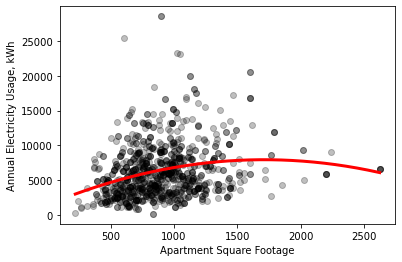

In [ ]:
RECS_APT_bootstrap = RECS_APT.sample(n=len(RECS_APT), replace=True, random_state=0)

X = RECS_APT_bootstrap.TOTSQFT_EN
y = RECS_APT_bootstrap.KWH

# Adding a column in the X matrices for the intercept
X_reshape = np.array(X).reshape(-1, 1)

# Generate new feature matrices consisting of all polynomial combinations
# of Apartment Square Footage of order 2 or less
poly = PolynomialFeatures(2)
X_poly2 = poly.fit_transform(X_reshape)

# Fit the polynomial regression of order 2 (quadratic)
regr.fit(X_poly2, y)

# Print the coefficients
print('The coefficients (betas as shown in the equation above) are:')
print('Beta_0 = ', regr.intercept_)
print('Beta_1 = ', regr.coef_[1])
print('Beta_2 = ', regr.coef_[2])

# Plot
x = np.arange(min(X),max(X), .01)
xx = np.c_[np.ones(len(x)), x, x**2]
y_curve = np.dot(xx, regr.coef_.transpose())+regr.intercept_

plt.scatter(X, y,  color='black', alpha = 0.25)
plt.plot(x, y_curve, color='red', linewidth=3)
plt.xlabel('Apartment Square Footage')
plt.ylabel('Annual Electricity Usage, kWh')
plt.show()

I use 1,000 bootstrap samples to get 1,000 values for each of the three coefficients for a second order polynomial, calculate the mean, standard deviation, and 95% confidence interval for each of the coefficients.

In [ ]:

#create arrays to stare coefficients calculated
coef_0 = []
coef_1 = []
coef_2 = []

for k in range(1,1001):
    RECS_APT_bootstrap = RECS_APT.sample(n=len(RECS_APT), replace=True)

    X = RECS_APT_bootstrap.TOTSQFT_EN
    y = RECS_APT_bootstrap.KWH

    # Adding a column in the X matrices for the intercept
    X_reshape = np.array(X).reshape(-1, 1)

    # Generate new feature matrices consisting of all polynomial combinations
    # of Apartment Square Footage of order 2 or less
    poly = PolynomialFeatures(2)
    X_poly2 = poly.fit_transform(X_reshape)

    # Fit the polynomial regression of order 2 (quadratic)
    regr.fit(X_poly2, y)

    #add coefficients to dataframe
    coef_0.append(regr.intercept_)
    coef_1.append(regr.coef_[1])
    coef_2.append(regr.coef_[2])

mean_0 = np.mean(coef_0)
mean_1 = np.mean(coef_1)
mean_2 = np.mean(coef_2)

std_0 = np.std(coef_0)
std_1 = np.std(coef_1)
std_2 = np.std(coef_2)


print('The mean for coefficient 0, 1, 3 respectively are:')
print(mean_0, mean_1, mean_2)
print('The standard deviation for coefficient 0, 1, 3 respectively are:')
print(std_0, std_1, std_2)
print('The 95% confidence interval coefficient 0, 1, 3 respectively are:')
print('[', mean_0 - 2*std_0, ',',mean_0 + 2*std_0,']')
print('[', mean_1 - 2*std_1, ',',mean_1 + 2*std_1,']')
print('[', mean_2 - 2*std_2, ',',mean_2 + 2*std_2,']')

The mean for coefficient 0, 1, 3 respectively are:
1416.564194475111 7.519651272091209 -0.0022151767795992178
The standard deviation for coefficient 0, 1, 3 respectively are:
636.7200934661289 1.2443567814415715 0.0005485722549289534
The 95% confidence interval coefficient 0, 1, 3 respectively are:
[ 143.12400754285318 , 2690.004381407369 ]
[ 5.030937709208066 , 10.008364834974351 ]
[ -0.0033123212894571245 , -0.001118032269741311 ]


### Some thoughts: Firstly the 95% confidence intevals for all coefficients don't include zero so we can reject the null hypothesis at the 0.05 level, and, secondly, all the coefficients fall within their respective 95% confidence intervals so there is a 95% probability that the values obtained in StatsModel are true